### Forest structure using PDAL + Python

Dr Adam Steer, November 2019.

In [1]:
NODATA_VALUE = -9999
LCF_HEIGHTS = [0, 0.05, 0.5, 1, 2, 3]


In [2]:
#imports
import pdal
import numpy as np
import json

from shapely.geometry import Point
from shapely.geometry import MultiPolygon
from shapely.geometry import box
#from shapely.strtree import STRtree

import geopandas as gpd
import pandas as pd
import osmnx as ox

import os

import sys

sys.path.insert(0, os.path.abspath('../'))
sys.path.insert(0, os.path.abspath('../../callingelvis'))

# not using this, using geopandas instead
from rtree import index

# this is needed to create a raster from the output array
from osgeo import gdal
import osgeo.osr as osr

In [4]:
from callingelvis import anybodyhome

import forestmetrics.forestmetrics as metrics
import forestmetrics.utils as forestutils

#import forestpipeline


In [5]:
def compute_tern_products(metadata, points, sindex, resolution, lasfile, outpath):
    """
    Wrapper to iterate over the input data and generate rasters for each product.
    
    *note this part could be paralellised - maybe per-product, or per-cell
    
    Each grid square processed in this loop corresponds to one pixel in an output raster.
    
    """
    
    #set up an 'output resolution' sized grid - like a fishnet grid.
    # each polygon in the resulting set covers an area of 'resolution X resolution'
    pixel_grid = forestutils.gen_raster_cells(metadata, resolution)
    
    #set up output rasters
    
    # get tile width and height
    tile_width = metadata["metadata"]["readers.las"]["maxx"] - metadata["metadata"]["readers.las"]["minx"]
    tile_height = metadata["metadata"]["readers.las"]["maxy"] - metadata["metadata"]["readers.las"]["miny"]

    raster_xsize = int(np.ceil(tile_width) / resolution)
    raster_ysize = int(np.ceil(tile_height) / resolution)
    
    #replicate for all products...
    vh_raster = np.zeros((raster_xsize, raster_ysize))
    vcf_raster = np.zeros((raster_xsize, raster_ysize))
    cth_raster = np.zeros((raster_xsize, raster_ysize))
    cbh_raster = np.zeros((raster_xsize, raster_ysize))
    fbf_raster = np.zeros((raster_xsize, raster_ysize))
    cli_raster = np.zeros((raster_xsize, raster_ysize))
    density_raster = np.zeros((raster_xsize, raster_ysize))
    
    veg_below_dict = {}

    veg_below_dict["all"] = np.zeros((raster_xsize, raster_ysize))
    for height in LCF_HEIGHTS:
        veg_below_dict[str(height)] = np.zeros((raster_xsize, raster_ysize))
    
    #internal loop around grid squares covering the LAS tile.
    # this is another ppoint for parallelisation - since we can set up a list of geometries
    # and cast that at multipuple processes, setting up one process per grid square
    # another way to do this would be to recast this loop block into a function which can  
    # be called by one process per product
    # the second strategy seems easier, then only one process is trying to write into each
    # output array.
    
    for pixel in pixel_grid:
        
        #compute output array index for this cell:
        poly_x, poly_y = pixel.centroid.xy
        
        poly_base_x = poly_x[0] - metadata["metadata"]["readers.las"]["minx"]
        poly_base_y = poly_y[0] - metadata["metadata"]["readers.las"]["miny"]
        
        array_x = int(np.floor((poly_base_x / (resolution)) ))
        array_y = int(np.floor((poly_base_y / (resolution)) ))
                
        #get points for this cell
        matches = forestutils.get_cell_points(pixel, points, sindex)
        
        #compute in order
        #VH
        
        vh_raster[array_x, array_y] = metrics.comp_vh(matches)
        
        #VCF
        vcf_raster[array_x, array_y] = metrics.comp_vcf(matches)
        
        #LCF - long-ish process..
        # compute a dictionary of points below height thresholds
        veg_below = metrics.comp_veg_layers(matches, LCF_HEIGHTS)
        
        # add the first element of the dictionary to a raster output
        veg_below_dict["all"][array_x, array_y] = veg_below["all"]
        
        #iterate over the height thresholds and do likewise...
        for height in LCF_HEIGHTS:
            veg_below_dict[str(height)][array_x, array_y] = veg_below[str(height)]
        
        #CTH
        cth_raster[array_x, array_y] = metrics.comp_cth(matches)
        
        #CBH
        cbh_raster[array_x, array_y] = metrics.comp_cbh(matches)
        
        #FBF
        fbf_raster[array_x, array_y] = metrics.comp_fbf(matches)
        
        #CLI
        cli_raster[array_x, array_y] = metrics.comp_cli(matches)
        
        #density
        density_raster[array_x, array_y] = metrics.comp_density(matches, resolution)


    #end of computing stuff, time to make outputs...
    
    #compute LCF values given our height thresholded veg counts
    lcf = metrics.comp_lcf(veg_below_dict, vcf_raster)
    
    if (not os.path.isdir(outpath + "/dem")):
        os.mkdir(outpath + "/dem")
    
    dem = forestutils.comp_dem(lasfile, outpath, resolution)
    
    tern_products = {}
    tern_products["vh"] = vh_raster
    tern_products["vcf"] = vcf_raster
    tern_products["cth"] = cth_raster
    tern_products["cbh"] = cbh_raster
    tern_products["fbf"] = fbf_raster
    tern_products["cli"] = cli_raster
    tern_products["lcf_h"] = lcf["lcf_h"]
    tern_products["lcf_os"] = lcf["lcf_os"]
    tern_products["lcf_us"] = lcf["lcf_us"]
    tern_products["lcf_cf"] = lcf["lcf_cf"]
    tern_products["lcf_ef"] = lcf["lcf_ef"]
    tern_products["lcf_nsf"] = lcf["lcf_nsf"]
    tern_products["density"] = density_raster

    return(tern_products)

## Testing functionality using a local file
The following section generates metrics from a local LAZ file. Plugging in download mechanics from ELVIS will be added later

In [6]:
#lidar test file - Mt Ainslie, chosen for varied vegetation cover and topography
# this is pretty big, try it out if you've got more resources than my macbook pro!

# thinking ahead, there will probably end up being a file splitting pre-process for 
# tiles like these... capping at say, 20 mill points. Sorting data before splitting
# will be essential.

#lasfile = "/Volumes/Antares/ACT-lidar/8ppm/callingelvis-testdata/ACT2015_8ppm-C3-AHD_6966094_55.laz"

In [45]:
lasfile = "/Volumes/Antares/fire-test/NSW Government - Spatial Services-2/Point Clouds/AHD/StAlbans201709-LID2-C3-AHD_2866308_56_0002_0002/StAlbans201709-LID2-C3-AHD_2866308_56_0002_0002.las"

In [46]:
#lasfile = "../../callingelvis-sampledata/Berridale201802-LID2-C3-AHD_6585974_55_0002_0002.las"

In [47]:
# dump everything from memory
points = None
df = None
vcf_raster = None
cth_raster = None
fbf_raster = None

In [48]:
metadata = forestutils.readlasmetadata(lasfile)

In [49]:
%%time
# this part of the process is simply reading from the source file. No analysis yet.

points = forestutils.readlasfile(lasfile)

CPU times: user 18.9 s, sys: 380 ms, total: 19.3 s
Wall time: 19.9 s


In [50]:
# uncomment to examine LAS metadata
#metadata

In [51]:
%%time

#here we read points into a GeoDataFrame and dump the labelled array.
# this is a pretty expensive step RAM wise, we're duplicating all the points...

df = forestutils.pdal2df(points)

# set the points structured array to None, it isn't used anymore
points = None

CPU times: user 2min 40s, sys: 1.42 s, total: 2min 42s
Wall time: 2min 42s


In [52]:
%%time

# here we generate an RTree index on the dataframe using GeoPandas.
# also pretty expensive... 

sindex = forestutils.spatialindex(df)

CPU times: user 3min 11s, sys: 1.56 s, total: 3min 13s
Wall time: 3min 14s


In [53]:
# set an output resolution

resolution = 25

In [16]:
metadata["metadata"]["readers.las"]["minx"]

658000

In [54]:
%%time

#produce some rasters!

tern_products = compute_tern_products(metadata, df, sindex, resolution, lasfile, "../..")

../../dem/StAlbans201709-LID2-C3-AHD_2866308_56_0002_0002-DEM-25m.tif
CPU times: user 1min 7s, sys: 277 ms, total: 1min 7s
Wall time: 1min 8s


In [55]:
from matplotlib import pyplot as plt

%matplotlib inline

Text(0.5, 1.0, 'Vegetation cover fraction (VCF)')

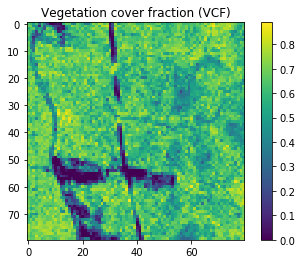

In [56]:
plt.imshow(np.rot90(tern_products["vcf"]))
plt.colorbar()
plt.title("Vegetation cover fraction (VCF)")

Text(0.5, 1.0, 'Canopy top height (CTH)')

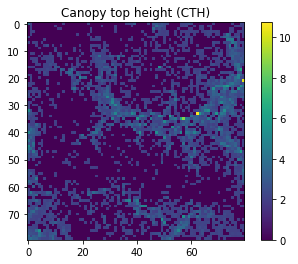

In [57]:
plt.imshow(np.rot90(tern_products["cth"]), vmin = 0)
plt.colorbar()
plt.title("Canopy top height (CTH)")


Text(0.5, 1.0, 'Canopy base height (CBH)')

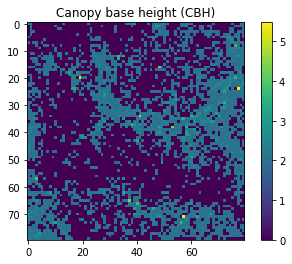

In [58]:
plt.imshow(np.rot90(tern_products["cbh"]), vmin = 0)
plt.colorbar()
plt.title("Canopy base height (CBH)")

Text(0.5, 1.0, 'Canopy top and base height difference')

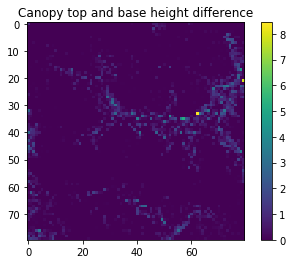

In [59]:
plt.imshow(np.rot90(tern_products["cth"] -tern_products["cbh"]))
plt.colorbar()
plt.title("Canopy top and base height difference")

Text(0.5, 1.0, 'Building fraction (FBF)')

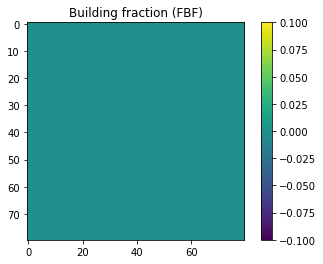

In [60]:
plt.imshow(np.rot90(tern_products["fbf"]))
plt.colorbar()
plt.title("Building fraction (FBF)")

Text(0.5, 1.0, 'Canopy Layering Index (CLI)')

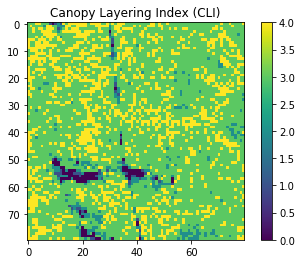

In [61]:
plt.imshow(np.rot90(tern_products["cli"]))
plt.colorbar()
plt.title("Canopy Layering Index (CLI)")

Text(0.5, 1.0, 'LCF_H')

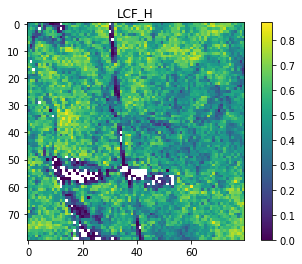

In [62]:
plt.imshow(np.rot90(tern_products["lcf_h"]))
plt.colorbar()
plt.title("LCF_H")

Text(0.5, 1.0, 'LCF_OS')

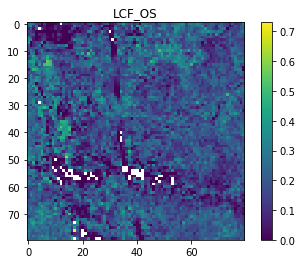

In [63]:
plt.imshow(np.rot90(tern_products["lcf_os"]))
plt.colorbar()
plt.title("LCF_OS")

Text(0.5, 1.0, 'LCF_US')

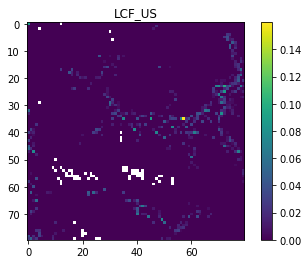

In [64]:
plt.imshow(np.rot90(tern_products["lcf_us"]))
plt.colorbar()
plt.title("LCF_US")

Text(0.5, 1.0, 'LCF_CF')

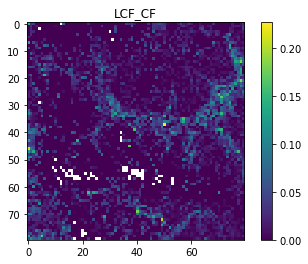

In [65]:
plt.imshow(np.rot90(tern_products["lcf_cf"]))
plt.colorbar()
plt.title("LCF_CF")

Text(0.5, 1.0, 'density')

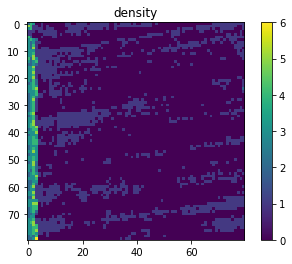

In [66]:
plt.imshow(np.rot90(tern_products["density"]))
plt.colorbar()
plt.title("density")

In [ ]:
polygons = forestutils.gen_raster_cells(metadata, resolution)

In [ ]:
polygons[40]

In [ ]:
matches = forestutils.get_cell_points(polygons[55], df, sindex)

In [ ]:
metrics.comp_cli(matches)

In [ ]:
metrics.comp_density(matches, resolution)

## code purgatory

In [ ]:

# an attempt at building an index without pandas. Pandas was far easier
"""
%%time


## rtree index building straight from the point dataset... which also duplicates the point set...

idx = index.Index()
for pid, point in enumerate(points[0]):
    idx.insert(pid, (point[0], point[1],point[0], point[1]), point)
"""

In [ ]:
## for raster writing later...

In [ ]:
#set up GDAL parameters
    
    wktcrs = metadata["metadata"]["readers.las"]["comp_spatialreference"]
    
    raster_parameters = {}
    raster_parameters["width"] = np.shape(vcf_raster)[0]
    raster_parameters["height"] = np.shape(vcf_raster)[1]
    raster_parameters["upperleft_x"] = metadata["metadata"]["readers.las"]["minx"]
    raster_parameters["upperleft_y"] = metadata["metadata"]["readers.las"]["maxy"]
    raster_parameters["resolution"] = resolution
    raster_parameters["projection"] = wktcrs
    
    fileroot = forestutils.make_file_rootname(lasfile)
    print(fileroot)
    
    if (not os.path.isdir(outpath + "/vcf")):
        os.mkdir(outpath + "/vcf")
    if (not os.path.isdir(outpath + "/cth")):
        os.mkdir(outpath + "/cth")
    if (not os.path.isdir(outpath + "/cbh")):
        os.mkdir(outpath + "/cbh")
    if (not os.path.isdir(outpath + "/fbf")):
        os.mkdir(outpath + "/fbf")
    if (not os.path.isdir(outpath + "/cli")):
        os.mkdir(outpath + "/cli")
        
    #lcf will hold 3 output rasters
    if (not os.path.isdir(outpath + "/lcf")):
        os.mkdir(outpath + "/lcf")


    
    #set output filenames
    vcf_raster_path = os.path.join(outpath,
                                   "vcf",
                                   fileroot + "-VCF-" + str(resolution) + "m.tiff")
    
    print(vcf_raster_path)
    cth_raster_path = outpath + "/cth/" + fileroot + "-CTH-" + str(resolution) + "m.tiff"
    cbh_raster_path = outpath + "/cbh/" + fileroot + "-CBH-" + str(resolution) + "m.tiff"
    fbf_raster_path = outpath + "/fbf/" + fileroot + "-FBF-" + str(resolution) + "m.tiff"
    cli_raster_path = outpath + "/cli/" + fileroot + "-CLI-" + str(resolution) + "m.tiff"


    #write geotiffs and return arrays for inspection...
    
    #TO DO:
    # - density
    # - lcf products

    forestutils.write_product_geotiff(vcf_raster, vcf_raster_path, raster_parameters)
    forestutils.write_product_geotiff(cth_raster, cth_raster_path, raster_parameters)
    forestutils.write_product_geotiff(cbh_raster, cbh_raster_path, raster_parameters)
    forestutils.write_product_geotiff(fbf_raster, fbf_raster_path, raster_parameters)
    forestutils.write_product_geotiff(cli_raster, cli_raster_path, raster_parameters)
    